# Option A - Download Data

In [ ]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00


Load Modules and Define Helper Functions

In [ ]:
import os
import time
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


####### Conceptual Concepts (CC3M) Code from Huggingface #########
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image

from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

#############################################################



Build Directory Structure

In [ ]:
basedir = 'Fake2M'
for split in ['train', 'val']:
    for label in ['fake', 'real']:
        path = os.path.join(basedir, split, label)
        if not os.path.exists(path):
            os.makedirs(path)

Helper Functions for retrieving data to create dataset

In [ ]:
def iterate_urls_like(url, count):
    left, right = url.split('.tar.gz.')
    num, right = right.split('?')
    pad = len(num)
    urls = []
    for idx in range(count):
        urls += [f'{left}.tar.gz.{idx:0>{pad}}?{right}']
    return urls

def download_fake2m_tarballs(url, split='train', label='fake', n=1):
    start_time = time.time()
    if n > 1:
        url_template = url
        for url in iterate_urls_like(url, n):
            print(f"Downloading Tarball from {url}")
            t0 = time.time()
            os.system(f'wget {url}')
            print(f"Downloaded Tarball in {time.time() - t0:.1f} seconds")
            fname = url.split('/')[-1]
            new_fname = fname.split('?')[0]
            os.rename(fname, new_fname)
        base_fname = '.'.join(fname.split('.')[:-1])
        t0 = time.time()
        print("Concatenating Files")
        os.system(f'cat {base_fname}.* > {base_fname}')
        print(f"Concatenated Files in {time.time() - t0:.1f} seconds")
        print("Removing Extra Files")
        os.system(f'rm {base_fname}.*')
    else:
        print(f"Downloading Tarball from {url}")
        t0 = time.time()
        os.system(f'wget {url}')
        print(f"Downloaded Tarball in {time.time() - t0:.1f} seconds")
        fname = url.split('/')[-1]
        base_fname = '.'.join(fname.split('.')[:-1])
        os.rename(fname, base_fname)
    print("Untarring Tarball")
    t0 = time.time()
    os.system(f'tar -xzf "{base_fname}" -C Fake2M/{split}/{label}')
    print(f"Untarred Tarball in {time.time() - t0:.1f} seconds")
    os.remove(base_fname)
    elapsed = time.time() - start_time

    # print("Compressing Images")
    # for cur_path, directories, files in os.walk(directory):
    #     for f in files:
    #         save_transform(os.path.join(cur_path, f), delete=True)

    return elapsed

def get_cc3m_images(num_train, num_val, num_threads=100, timeout=5, batch_size=500):

    if not os.path.exists('Fake2M/train/real/CC3M'):
        os.makedirs('Fake2M/train/real/CC3M')
    if not os.path.exists('Fake2M/val/real/CC3M'):
        os.makedirs('Fake2M/val/real/CC3M')

    # On average, 22.06% of the images could not be downloaded or saved. Increase expected
    # number of images by a factor around this amount to get the desired quantity
    print("Expected to lose 22.06% of images downloaded, increasing retrievals by 23%")
    num_train = int(num_train * 1.23)
    num_val = int(num_val * 1.23)
    print(f"Attempting to download a total of {num_train} train images and {num_val} val images")

    train_pct = num_train / (num_train + num_val)

    max_images = num_train + num_val
    cc3m_dataset = load_dataset("conceptual_captions", split='train', streaming=True)
    subset = cc3m_dataset.take(max_images)
    image_urls = [d['image_url'] for d in subset]
    image_captions = [d['caption'] for d in subset]
    subset = {'image_url':image_urls, 'caption':image_captions}

    # Estimate 45 sec total for 1000 images (20s download, 25s write to disk)
    total = 0
    total_saved = 0
    start_time = time.time()
    for start in range(0, max_images, batch_size):
        t0 = time.time()
        batch = {
            'image_url': image_urls[start:start+batch_size],
            'caption': image_captions[start:start+batch_size]
        }

        batch = fetch_images(batch, num_threads=num_threads, timeout=timeout)

        n_saved = 0
        for i,img in enumerate(batch['image']):
            i = start + i
            if img:
                split = 'train' if i < num_train else 'val'
                try:
                    img.save(f'Fake2M/{split}/real/CC3M/{i:>07}.jpg')
                    n_saved += 1
                except:
                    # print(f"Could not write image {i} to disk")
                    pass
        total += batch_size
        total_saved += n_saved
        print(f"Downloaded and Saved {n_saved}/{batch_size} images in {time.time() - t0:.1f} seconds (total = {total_saved}/{total} images in {(time.time() - start_time)/60.0:.1f} minutes)")

Download Data

In [ ]:
# train fake urls
sdv15_cc1m_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/train/SDv15R-CC1M/SDv15R-dpmsolver-25-1M/SDv15R-CC1M.tar.gz.000?download=true"
if_1m_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/train/IFv1-CC1M/IFv1-dpmsolver%2B%2B-50-1M/IF-CC1M.tar.gz.00?download=true"
stylegan3_80k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/train/stylegan3-80K/stylegan3-80K.tar.gz.00?download=true"

# val fake urls
if_cc95k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/IF-CC95K/IF-CC95K.tar.gz.0?download=true"
sdv15_cc30k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/SDv15-CC30K/SDv15-CC30K.tar.gz.0?download=true"
sdv21_cc15k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/SDv21-CC15K/SDv21-CC15K.tar.gz.0?download=true"
cogview2_22k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/cogview2-22K/cogview2-22K.tar.gz.0?download=true"
stylegan3_60k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/stylegan3-60K/stylegan3-60K.tar.gz.00?download=true"
midjourney_5k_url = "https://huggingface.co/datasets/InfImagine/FakeImageDataset/resolve/main/ImageData/val/Midjourneyv5-5K/Midjourneyv5-5K.tar.gz?download=true"

for url_template, count, split, label in [
    (sdv15_cc1m_url, 4, 'train', 'fake'), # Max 124
    (if_1m_url, 4, 'train', 'fake'), # Max 38
    (stylegan3_80k_url, 4, 'train', 'fake'), # Max 32
    (if_cc95k_url, 2, 'val', 'fake'), # Max 4
    (sdv15_cc30k_url, 3, 'val', 'fake'), # Max 5
    (sdv21_cc15k_url, 3, 'val', 'fake'), # Max 3
    (cogview2_22k_url, 2, 'val', 'fake'), # Max 2
    (stylegan3_60k_url, 2, 'val', 'fake'), # Max 20
    (midjourney_5k_url, 1, 'val', 'fake'), # Max 1

]:
    download_fake2m_tarballs(url_template, split, label, count)

Downloaded Tarball in 65.5 seconds
Downloaded Tarball in 64.7 seconds
Downloaded Tarball in 69.1 seconds
Downloaded Tarball in 65.0 seconds
Concatenating Files
Concatenated Files in 61.4 seconds
Removing Extra Files
Untarring Tarball
Untarred Tarball in 113.4 seconds
Downloaded Tarball in 67.6 seconds
Downloaded Tarball in 67.1 seconds
Downloaded Tarball in 67.7 seconds
Downloaded Tarball in 64.9 seconds
Concatenating Files
Concatenated Files in 40.1 seconds
Removing Extra Files
Untarring Tarball
Untarred Tarball in 129.6 seconds
Downloaded Tarball in 69.7 seconds
Downloaded Tarball in 65.2 seconds
Downloaded Tarball in 64.1 seconds
Downloaded Tarball in 66.2 seconds
Concatenating Files
Concatenated Files in 33.3 seconds
Removing Extra Files
Untarring Tarball
Untarred Tarball in 114.9 seconds
Downloaded Tarball in 62.9 seconds
Downloaded Tarball in 67.9 seconds
Concatenating Files
Concatenated Files in 16.9 seconds
Removing Extra Files
Untarring Tarball
Untarred Tarball in 88.4 seconds

In [ ]:
# get real images from cc3m for train and val datasets

#### Notes on retrieving the data #####
# RAW 57 sec for 2000 images @ 2000 batch size, 100 threads
# => Increase number of images retrieved by a factor of 1.221 (round to 1.23) (built into code)
# => 70 sec to actually retrieve 2000 images since some are lost during the process

# Raw statistics without adjusting for loss:
# => 570 sec (9.5 min) for 20K Images
# => 47.5 min for 100K Images
# => 95 min for 200K Images

# Adjusted statistics accounting for loss:
# => 700 sec (11.67 min) for 20K Images
# => 58.3 min for 100K Images
# => 116.7 min for 200K Images

# Do we have enough storage for this? Would crop/resizing everything to 256 be enough space?
# Preliminary estimate @ 20Kb per 256x256 JPEG image with 2M images leads to 40 GB of storage, which is available.

# Training time on 6590 train images + 1648 val images is X per epoch
#   (batch_size = 8, lr = 5e-5)
# Assuming the training time scales linearly with size of dataset

get_cc3m_images(num_train=123000, num_val=123000, num_threads=2000, batch_size=2000)

Expected to lose 22.06% of images downloaded, increasing retrievals by 23%
Attempting to download a total of 151290 train images and 151290 val images
Downloaded and Saved 1654/2000 images in 37.9 seconds (total = 1654/2000 images in 0.6 minutes)
Downloaded and Saved 1619/2000 images in 37.9 seconds (total = 3273/4000 images in 1.3 minutes)
Downloaded and Saved 1639/2000 images in 39.8 seconds (total = 4912/6000 images in 1.9 minutes)
Downloaded and Saved 1669/2000 images in 36.2 seconds (total = 6581/8000 images in 2.5 minutes)
Downloaded and Saved 1672/2000 images in 53.3 seconds (total = 8253/10000 images in 3.4 minutes)
Downloaded and Saved 1618/2000 images in 51.4 seconds (total = 9871/12000 images in 4.3 minutes)
Downloaded and Saved 1628/2000 images in 36.9 seconds (total = 11499/14000 images in 4.9 minutes)
Downloaded and Saved 1620/2000 images in 37.3 seconds (total = 13119/16000 images in 5.5 minutes)
Downloaded and Saved 1602/2000 images in 41.2 seconds (total = 14721/18000 

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Downloaded and Saved 1621/2000 images in 50.6 seconds (total = 34117/42000 images in 15.0 minutes)
Downloaded and Saved 1611/2000 images in 38.0 seconds (total = 35728/44000 images in 15.6 minutes)
Downloaded and Saved 1641/2000 images in 38.3 seconds (total = 37369/46000 images in 16.3 minutes)
Downloaded and Saved 1616/2000 images in 37.9 seconds (total = 38985/48000 images in 16.9 minutes)
Downloaded and Saved 1600/2000 images in 38.3 seconds (total = 40585/50000 images in 17.5 minutes)
Downloaded and Saved 1636/2000 images in 41.3 seconds (total = 42221/52000 images in 18.2 minutes)
Downloaded and Saved 1636/2000 images in 39.6 seconds (total = 43857/54000 images in 18.9 minutes)
Downloaded and Saved 1629/2000 images in 38.2 seconds (total = 45486/56000 images in 19.5 minutes)
Downloaded and Saved 1598/2000 images in 37.1 seconds (total = 47084/58000 images in 20.1 minutes)
Downloaded and Saved 1620/2000 images in 36.1 seconds (total = 48704/60000 images in 20.7 minutes)
Downloaded

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Downloaded and Saved 1621/2000 images in 40.3 seconds (total = 77869/96000 images in 32.7 minutes)
Downloaded and Saved 1631/2000 images in 35.9 seconds (total = 79500/98000 images in 33.3 minutes)
Downloaded and Saved 1572/2000 images in 37.9 seconds (total = 81072/100000 images in 34.0 minutes)
Downloaded and Saved 1606/2000 images in 39.5 seconds (total = 82678/102000 images in 34.6 minutes)
Downloaded and Saved 1616/2000 images in 40.8 seconds (total = 84294/104000 images in 35.3 minutes)
Downloaded and Saved 1602/2000 images in 39.9 seconds (total = 85896/106000 images in 36.0 minutes)
Downloaded and Saved 1616/2000 images in 38.3 seconds (total = 87512/108000 images in 36.6 minutes)
Downloaded and Saved 1645/2000 images in 38.4 seconds (total = 89157/110000 images in 37.2 minutes)
Downloaded and Saved 1616/2000 images in 40.4 seconds (total = 90773/112000 images in 37.9 minutes)
Downloaded and Saved 1647/2000 images in 37.4 seconds (total = 92420/114000 images in 38.5 minutes)
Do

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Downloaded and Saved 1647/2000 images in 39.7 seconds (total = 97335/120000 images in 40.6 minutes)
Downloaded and Saved 1598/2000 images in 41.3 seconds (total = 98933/122000 images in 41.3 minutes)
Downloaded and Saved 1654/2000 images in 42.4 seconds (total = 100587/124000 images in 42.0 minutes)
Downloaded and Saved 1631/2000 images in 40.0 seconds (total = 102218/126000 images in 42.7 minutes)
Downloaded and Saved 1606/2000 images in 40.5 seconds (total = 103824/128000 images in 43.3 minutes)
Downloaded and Saved 1634/2000 images in 41.5 seconds (total = 105458/130000 images in 44.0 minutes)
Downloaded and Saved 1629/2000 images in 40.6 seconds (total = 107087/132000 images in 44.7 minutes)
Downloaded and Saved 1628/2000 images in 43.0 seconds (total = 108715/134000 images in 45.4 minutes)
Downloaded and Saved 1606/2000 images in 34.9 seconds (total = 110321/136000 images in 46.0 minutes)
Downloaded and Saved 1618/2000 images in 38.6 seconds (total = 111939/138000 images in 46.6 m

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Downloaded and Saved 1610/2000 images in 40.4 seconds (total = 123196/152000 images in 51.3 minutes)
Downloaded and Saved 1616/2000 images in 39.2 seconds (total = 124812/154000 images in 52.0 minutes)
Downloaded and Saved 1647/2000 images in 41.2 seconds (total = 126459/156000 images in 52.7 minutes)
Downloaded and Saved 1650/2000 images in 37.5 seconds (total = 128109/158000 images in 53.3 minutes)
Downloaded and Saved 1597/2000 images in 40.7 seconds (total = 129706/160000 images in 54.0 minutes)
Downloaded and Saved 1619/2000 images in 42.1 seconds (total = 131325/162000 images in 54.7 minutes)
Downloaded and Saved 1634/2000 images in 38.9 seconds (total = 132959/164000 images in 55.3 minutes)
Downloaded and Saved 1636/2000 images in 40.3 seconds (total = 134595/166000 images in 56.0 minutes)
Downloaded and Saved 1622/2000 images in 37.5 seconds (total = 136217/168000 images in 56.6 minutes)
Downloaded and Saved 1621/2000 images in 36.5 seconds (total = 137838/170000 images in 57.2

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Downloaded and Saved 1603/2000 images in 38.6 seconds (total = 179980/222000 images in 74.7 minutes)
Downloaded and Saved 1622/2000 images in 37.4 seconds (total = 181602/224000 images in 75.3 minutes)
Downloaded and Saved 1616/2000 images in 38.4 seconds (total = 183218/226000 images in 75.9 minutes)
Downloaded and Saved 1629/2000 images in 43.2 seconds (total = 184847/228000 images in 76.7 minutes)
Downloaded and Saved 1622/2000 images in 41.7 seconds (total = 186469/230000 images in 77.4 minutes)
Downloaded and Saved 1626/2000 images in 39.5 seconds (total = 188095/232000 images in 78.0 minutes)
Downloaded and Saved 1616/2000 images in 39.5 seconds (total = 189711/234000 images in 78.7 minutes)
Downloaded and Saved 1619/2000 images in 57.5 seconds (total = 191330/236000 images in 79.6 minutes)
Downloaded and Saved 1594/2000 images in 43.9 seconds (total = 192924/238000 images in 80.4 minutes)
Downloaded and Saved 1626/2000 images in 39.7 seconds (total = 194550/240000 images in 81.0

# Option B - Load Compressed Dataset from Drive (Use This)

Fake2M Dataset

In [1]:
# !pip install transformers
import time
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch

# Fake 2M Dataset
!gdown https://drive.google.com/uc?id=1hdVmSssXzjoMUD4F-agafqlrdyBQ3MRL
!tar xzf Fake2M.tar.gz
!rm Fake2M.tar.gz

# Artifact Dataset
!gdown https://drive.google.com/uc?id=1-JNvH5z6AGLp6qGvVYWkjk3Zx4T0HvES
!tar xzf Artifact.tar.gz
!rm Artifact.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1hdVmSssXzjoMUD4F-agafqlrdyBQ3MRL
To: /content/Fake2M.tar.gz
100% 4.60G/4.60G [00:47<00:00, 97.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-JNvH5z6AGLp6qGvVYWkjk3Zx4T0HvES
To: /content/Artifact.tar.gz
100% 1.02G/1.02G [00:10<00:00, 100MB/s]


# Create Dataset

In [6]:
import os
def get_image_filepaths(directory, shuffle=False):
    '''List all files within a directory (assumed to be images)'''
    filepaths = []
    for cur_path, directories, files in os.walk(directory):
        for file in files:
            filepaths += [os.path.join(cur_path, file)]
            # filepaths += [os.path.join(directory, cur_path, file)]
    if shuffle:
        np.random.shuffle(filepaths)
    return filepaths

def get_image_directories(directory):
    '''List all directories that contain files'''
    dirpaths = []
    for cur_path, directories, files in os.walk(directory):
        if len(files) > 0:
            dirpaths += [cur_path]
    return dirpaths

Create Dataset

In [2]:
import numpy as np
# from torchvision.io import read_image
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # Needed for Large images...

class FakeImageDataset(Dataset):

    def __init__(self, fake_dirs, real_dirs, max_fake=None, max_real=None, transform=None, target_transform=None, in_memory=False, sources=None):
        self.transform = transform
        self.target_transform = target_transform
        if os.path.isdir(fake_dirs[0]):
            self.fake_paths = self._getPaths(fake_dirs, max_fake)
            self.real_paths = self._getPaths(real_dirs, max_real)
        else:
            self.fake_paths = fake_dirs
            self.real_paths = real_dirs
        self.paths = np.concatenate([self.fake_paths, self.real_paths])
        self.labels = np.concatenate([np.zeros(len(self.fake_paths)), np.ones(len(self.real_paths))])
        self.in_memory = in_memory
        self.all_images = [Image.open(pth).convert('RGB') for pth in self.paths] if in_memory else []
        if sources:
            sources = set(sources)
            self.fake_paths = [p for p in self.fake_paths if p.split('/')[-2] in sources]
            self.real_paths = [p for p in self.real_paths if p.split('/')[-2] in sources]


    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.all_images[idx] if self.in_memory else Image.open(self.paths[idx]).convert('RGB')
        pixel_values = self.transform(image) if self.transform else np.array(image)
        generator = self.paths[idx].split('/')[-2]
        if self.target_transform:
            label = self.target_transform(label)
        return {"image": image, "label": label, "pixel_values": pixel_values, 'generator':generator}

    def __len__(self):
        return len(self.paths)

    def _getPaths(self, dirs, max_count=None):
        paths = []
        if max_count:
            if type(max_count) == int:
                paths = np.concatenate([[os.path.join(d,f) for f in os.listdir(d)] for d in dirs])
                np.random.shuffle(paths) # Get samples from each dir
                paths = paths[:max_count]
            else:
                for d in dirs:
                    n = max_count[os.path.basename(d)]
                    all_paths = [os.path.join(d,f) for f in os.listdir(d)]
                    paths += np.random.choice(all_paths, n).tolist()
                paths = np.array(paths)
        else:
            paths = np.concatenate([[os.path.join(d,f) for f in os.listdir(d)] for d in dirs])
        return paths

Specify Transforms for DataLoader

In [3]:
from transformers import ConvNextFeatureExtractor # Look into ConvNextImageProcessor
from torchvision.transforms import (
    ToTensor,
    Compose,
    CenterCrop,
    Normalize,
    RandomResizedCrop,
    RandomHorizontalFlip,
    Resize
)

feature_extractor = ConvNextFeatureExtractor.from_pretrained('facebook/convnext-small-224')

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    # RandomResizedCrop(feature_extractor.size['shortest_edge']), # Use this if downloading images
    CenterCrop(feature_extractor.size['shortest_edge']), # Use this if using compressed, fixed size images
    RandomHorizontalFlip(),
    ToTensor(),
    # normalize
])

# Used for displaying example images, excludes normalization for visualization
example_transform = Compose([
    # RandomResizedCrop(feature_extractor.size['shortest_edge']), # Use this if downloading images
    CenterCrop(feature_extractor.size['shortest_edge']), # Use this if using compressed, fixed size images
    RandomHorizontalFlip(),
    ToTensor()
])

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


Inspect Dataset

In [ ]:
fake_train_filepaths = get_image_filepaths('Fake2M/train/fake') + get_image_filepaths('Artifact/train/fake')
real_train_filepaths = get_image_filepaths('Fake2M/train/real') + get_image_filepaths('Artifact/train/real')
fake_val_filepaths = get_image_filepaths('Fake2M/val/fake') + get_image_filepaths('Artifact/val/fake')
real_val_filepaths = get_image_filepaths('Fake2M/val/real') + get_image_filepaths('Artifact/val/real')

num_fake_train = len(fake_train_filepaths)
num_real_train = len(real_train_filepaths)
num_fake_val = len(fake_val_filepaths)
num_real_val = len(real_val_filepaths)

print("num_fake_train: ", num_fake_train)
print("num_real_train: ", num_real_train)
print("num_fake_val: ", num_fake_val)
print("num_real_val: ", num_real_val)

num_fake = num_fake_train + num_fake_val
num_real = num_real_train + num_real_val

total_images = num_fake + num_real

fake_train_dirs = get_image_directories('Fake2M/train/fake') + get_image_directories('Artifact/train/fake')
real_train_dirs = get_image_directories('Fake2M/train/real') + get_image_directories('Artifact/train/real')
fake_val_dirs = get_image_directories('Fake2M/val/fake') + get_image_directories('Artifact/val/fake')
real_val_dirs = get_image_directories('Fake2M/val/real') + get_image_directories('Artifact/val/real')

print('\nImage Count per Directory')
for dirlist, category in zip([fake_train_dirs, real_train_dirs, fake_val_dirs, real_val_dirs],
                   ['Fake Train', 'Real Train', 'Fake Validation', 'Real Validation']):
    print(f'\n---------{category}--------')
    for directory in dirlist:
        print(f'{os.path.basename(directory)}: {len(os.listdir(directory))}')


Image Count per Directory

---------Fake Train--------
IF-CC1M: 108668
SDv15R-CC1M: 32539
stylegan3-t-ffhqu-1024x1024: 9084
stylegan3-t-metfaces-1024x1024: 651
big_gan: 10000
stable_diffusion: 15000

---------Real Train--------
CC3M: 122591
imagenet: 20000

---------Fake Validation--------
SDv15R-dpmsolver-25-15K: 15841
SDv15-dpmsolver-25-15K: 337
stylegan3-t-ffhqu-1024x1024: 4850
IF-ddim-50-15K: 15841
IF-dpmsolver++-25-15K: 15841
IF-dpmsolver++-10-15K: 13038
IF-ddpm-50-15K: 15841
Midjourneyv5-5K: 5448
SDv2-dpmsolver-25-10K: 15841
cogview2-22K: 22317
projected_gan: 5000
latent_diffusion: 5000
vq_diffusion: 5000
pro_gan: 5000
star_gan: 5000
ddpm: 896

---------Real Validation--------
CC3M: 122500
afhq: 5000
metfaces: 1336
celebahq: 5000
landscape: 4318
lsun: 5000
ffhq: 5000
coco: 20000


In [40]:
train_val_regimes = {
    'fake2m': {
        'fake_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-ffhqu-1024x1024', shuffle=True)[:4500],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-metfaces-1024x1024', shuffle=True)[:500],
            get_image_filepaths('Fake2M/train/fake/IF-CC1M', shuffle=True)[:5000],
            get_image_filepaths('Fake2M/train/fake/SDv15R-CC1M', shuffle=True)[:5000],
        ]).tolist(),
        'real_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/real/CC3M', shuffle=True)[:15000],
        ]).tolist(),
        'fake_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-10-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddim-50-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddpm-50-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/cogview2-22K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/stylegan3-60K/stylegan3-t-ffhqu-10,24x1024', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15-dpmsolver-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15R-dpmsolver-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv21-CC15K/SDv2-dpmsolver-25-10K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/Midjourneyv5-5K', shuffle=True)[:100],
        ]).tolist(),
        'real_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/real/CC3M', shuffle=True)[:1000],
        ]).tolist(),
    },
    'gan->diff': {
        'fake_train_filepaths': np.hstack([
            get_image_filepaths('Artifact/val/fake/pro_gan', shuffle=True)[:2000],
            get_image_filepaths('Artifact/val/fake/star_gan', shuffle=True)[:2000],
            get_image_filepaths('Artifact/val/fake/projected_gan', shuffle=True)[:2000],
            get_image_filepaths('Artifact/train/fake/big_gan', shuffle=True)[:2000],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-ffhqu-1024x1024', shuffle=True)[:2000],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-metfaces-1024x1024', shuffle=True)[:2000],
        ]).tolist(),
        'real_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/real/CC3M', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/landscape', shuffle=True)[:3000],
            get_image_filepaths('Artifact/train/real/imagenet', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/coco', shuffle=True)[:3000],
        ]).tolist(),
        'fake_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/fake/IF-CC1M', shuffle=True)[:100],
            get_image_filepaths('Artifact/train/fake/stable_diffusion', shuffle=True)[:100],
            get_image_filepaths('Fake2M/train/fake/SDv15R-CC1M', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-10-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddim-50-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddpm-50-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/cogview2-22K', shuffle=True)[:100],
            # get_image_filepaths('Fake2M/val/fake/stylegan3-60K/stylegan3-t-ffhqu-10,24x1024', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15-dpmsolver-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15R-dpmsolver-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv21-CC15K/SDv2-dpmsolver-25-10K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/Midjourneyv5-5K', shuffle=True)[:100],
            get_image_filepaths('Artifact/val/fake/vq_diffusion', shuffle=True)[:100],
            get_image_filepaths('Artifact/val/fake/latent_diffusion', shuffle=True)[:100],
            get_image_filepaths('Artifact/val/fake/ddpm', shuffle=True)[:100],
        ]).tolist(),
        'real_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/real/CC3M', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/celebahq', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/lsun', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/afhq', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/metfaces', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/ffhq', shuffle=True)[:250],
        ]).tolist(),
    },
    'diff->gan': {
        'fake_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/fake/IF-CC1M', shuffle=True)[:1000],
            get_image_filepaths('Artifact/train/fake/stable_diffusion', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/train/fake/SDv15R-CC1M', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-10-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-25-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddim-50-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddpm-50-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15-dpmsolver-25-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15R-dpmsolver-25-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/SDv21-CC15K/SDv2-dpmsolver-25-10K', shuffle=True)[:1000],
            get_image_filepaths('Artifact/val/fake/vq_diffusion', shuffle=True)[:1000],
            get_image_filepaths('Artifact/val/fake/latent_diffusion', shuffle=True)[:1000],
            get_image_filepaths('Artifact/val/fake/ddpm', shuffle=True)[:1000],
        ]).tolist(),
        'real_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/real/CC3M', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/landscape', shuffle=True)[:3000],
            get_image_filepaths('Artifact/train/real/imagenet', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/coco', shuffle=True)[:3000],
        ]).tolist(),
        'fake_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/fake/stylegan3-60K/stylegan3-t-ffhqu-10,24x1024', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/cogview2-22K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/Midjourneyv5-5K', shuffle=True)[:100],
            get_image_filepaths('Artifact/val/fake/pro_gan', shuffle=True)[:100],
            get_image_filepaths('Artifact/val/fake/star_gan', shuffle=True)[:100],
            get_image_filepaths('Artifact/val/fake/projected_gan', shuffle=True)[:100],
            get_image_filepaths('Artifact/train/fake/big_gan', shuffle=True)[:100],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-ffhqu-1024x1024', shuffle=True)[:100],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-metfaces-1024x1024', shuffle=True)[:100],
        ]).tolist(),
        'real_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/real/CC3M', shuffle=True)[:150],
            get_image_filepaths('Artifact/val/real/celebahq', shuffle=True)[:150],
            get_image_filepaths('Artifact/val/real/lsun', shuffle=True)[:150],
            get_image_filepaths('Artifact/val/real/afhq', shuffle=True)[:150],
            get_image_filepaths('Artifact/val/real/metfaces', shuffle=True)[:150],
            get_image_filepaths('Artifact/val/real/ffhq', shuffle=True)[:150],
        ]).tolist(),
    },
    'both->seen+unseen': {
        'fake_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/fake/SDv15R-CC1M', shuffle=True)[:5000],
            get_image_filepaths('Fake2M/train/fake/IF-CC1M', shuffle=True)[:5000],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-ffhqu-1024x1024', shuffle=True)[:4500],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-metfaces-1024x1024', shuffle=True)[:500],
            get_image_filepaths('Artifact/train/fake/stable_diffusion', shuffle=True)[:5000],
            # get_image_filepaths('Artifact/train/fake/big_gan', shuffle=True)[:100],
        ]).tolist(),
        'real_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/real/CC3M', shuffle=True)[:10000],
            get_image_filepaths('Artifact/train/real/imagenet', shuffle=True)[:10000],
        ]).tolist(),
        'fake_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-10-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-25-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddim-50-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddpm-50-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15-dpmsolver-25-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15R-dpmsolver-25-15K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/SDv21-CC15K/SDv2-dpmsolver-25-10K', shuffle=True)[:1000],
            get_image_filepaths('Fake2M/val/fake/cogview2-22K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/stylegan3-60K/stylegan3-t-ffhqu-10,24x1024', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/Midjourneyv5-5K', shuffle=True)[:100],
            # get_image_filepaths('Artifact/val/fake/vq_diffusion', shuffle=True)[:1000],
            # get_image_filepaths('Artifact/val/fake/latent_diffusion', shuffle=True)[:1000],
            # get_image_filepaths('Artifact/val/fake/ddpm', shuffle=True)[:1000],
            # get_image_filepaths('Artifact/val/fake/pro_gan', shuffle=True)[:100],
            # get_image_filepaths('Artifact/val/fake/star_gan', shuffle=True)[:100],
            # get_image_filepaths('Artifact/val/fake/projected_gan', shuffle=True)[:100],
        ]).tolist(),
        'real_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/real/CC3M', shuffle=True)[:1500],
            get_image_filepaths('Artifact/val/real/coco', shuffle=True)[:1500],
            # get_image_filepaths('Artifact/val/real/landscape', shuffle=True)[:3000],
            # get_image_filepaths('Artifact/val/real/celebahq', shuffle=True)[:150],
            # get_image_filepaths('Artifact/val/real/lsun', shuffle=True)[:150],
            # get_image_filepaths('Artifact/val/real/afhq', shuffle=True)[:150],
            # get_image_filepaths('Artifact/val/real/metfaces', shuffle=True)[:150],
            # get_image_filepaths('Artifact/val/real/ffhq', shuffle=True)[:150],
        ]).tolist(),
    },
    'both->unseen': {
        'fake_train_filepaths': np.hstack([
            get_image_filepaths('Artifact/val/fake/pro_gan', shuffle=True)[:2000],
            get_image_filepaths('Artifact/val/fake/star_gan', shuffle=True)[:2000],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-ffhqu-1024x1024', shuffle=True)[:2000],
            get_image_filepaths('Fake2M/train/fake/stylegan3-80K/stylegan3-t-metfaces-1024x1024', shuffle=True)[:2000],
            get_image_filepaths('Fake2M/train/fake/IF-CC1M', shuffle=True)[:2000],
            get_image_filepaths('Fake2M/train/fake/SDv15R-CC1M', shuffle=True)[:2000],
            get_image_filepaths('Artifact/train/fake/stable_diffusion', shuffle=True)[:2000],
        ]).tolist(),
        'real_train_filepaths': np.hstack([
            get_image_filepaths('Fake2M/train/real/CC3M', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/landscape', shuffle=True)[:3000],
            get_image_filepaths('Artifact/train/real/imagenet', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/coco', shuffle=True)[:3000],
            get_image_filepaths('Artifact/val/real/metfaces', shuffle=True)[:3000],
        ]).tolist(),
        'fake_val_filepaths': np.hstack([
            get_image_filepaths('Artifact/train/fake/big_gan', shuffle=True)[:200],
            get_image_filepaths('Artifact/val/fake/projected_gan', shuffle=True)[:200],
            # get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-10-15K', shuffle=True)[:100],
            # get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-dpmsolver++-25-15K', shuffle=True)[:100],
            # get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddim-50-15K', shuffle=True)[:100],
            # get_image_filepaths('Fake2M/val/fake/IF-CC95K/IF-ddpm-50-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/cogview2-22K', shuffle=True)[:200],
            # get_image_filepaths('Fake2M/val/fake/stylegan3-60K/stylegan3-t-ffhqu-10,24x1024', shuffle=True)[:100],
            # get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15-dpmsolver-25-15K', shuffle=True)[:100],
            # get_image_filepaths('Fake2M/val/fake/SDv15-CC30K/SDv15R-dpmsolver-25-15K', shuffle=True)[:100],
            get_image_filepaths('Fake2M/val/fake/SDv21-CC15K/SDv2-dpmsolver-25-10K', shuffle=True)[:200],
            get_image_filepaths('Fake2M/val/fake/Midjourneyv5-5K', shuffle=True)[:200],
            get_image_filepaths('Artifact/val/fake/vq_diffusion', shuffle=True)[:200],
            get_image_filepaths('Artifact/val/fake/latent_diffusion', shuffle=True)[:200],
            get_image_filepaths('Artifact/val/fake/ddpm', shuffle=True)[:200],
        ]).tolist(),
        'real_val_filepaths': np.hstack([
            get_image_filepaths('Fake2M/val/real/CC3M', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/celebahq', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/lsun', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/afhq', shuffle=True)[:250],
            get_image_filepaths('Artifact/val/real/ffhq', shuffle=True)[:250],
        ]).tolist(),
    }
}

# Optional - View Example Images from Train Dataset

In [16]:
print('Regimes: ', list(train_val_regimes.keys()))

Regimes:  ['fake2m', 'gan->diff', 'diff->gan', 'both->seen+unseen', 'both->unseen']


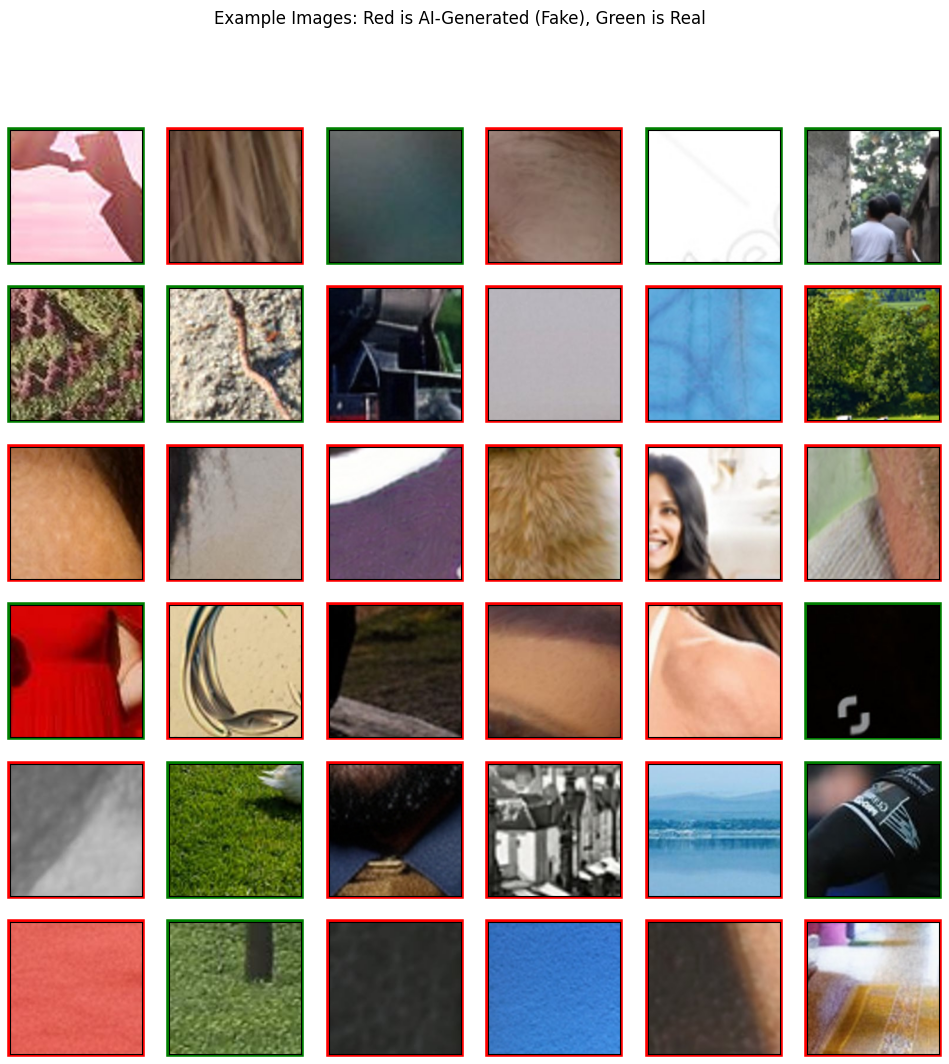

In [13]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

regime = 'fake2m'
example_fake_filepaths = train_val_regimes[regime]['fake_train_filepaths']
example_real_filepaths = train_val_regimes[regime]['real_train_filepaths']
example_dataset = FakeImageDataset(example_fake_filepaths, example_real_filepaths, transform=example_transform)

toPIL = ToPILImage()
fig, axs = plt.subplots(6,6)
fig.set_size_inches(12,12)
fig.bbox_inches = 0
fig.suptitle('Example Images: Red is AI-Generated (Fake), Green is Real')
for row, row_axs in enumerate(axs):
    for col, ax in enumerate(row_axs):
        idx = np.random.choice(len(example_dataset))
        res = example_dataset[idx]
        ax.imshow(toPIL(res['pixel_values']))
        # ax.imshow(res['image'], interpolation='nearest')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.tick_params(left = False, bottom = False)
        ax.patch.set_edgecolor('red' if int(res['label']) == 0 else 'green')
        ax.patch.set_linewidth(4)
        idx += 1

# Train Model - Validate on Test-Like Images

Two options:

1. Can train and validate on a split of the training data and then test on the validation images.

2. Can train on training data and validate on a split of the validation images, and then use the other portion of the validation images to test. Since the validation images could potentially be of a different class of image generators, this may be desireable since it will show early if the training process is actually learning to detect images of another type of generator. By training in this way, we can stop training much earlier if there are no real gains occuring. This is the process that ended up being used.

In [17]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from torch.utils.data import DataLoader

id2label = {
    0: "fake",
    1: "real"
}

label2id = {
    "fake": 0,
    "real": 1
}

num_classes = len(list(id2label.keys()))

# Need this for batching
def collate_fn(examples):
    pixel_values = torch.stack([e['pixel_values'] for e in examples])
    labels = torch.tensor([e['label'] for e in examples])
    return {"pixel_values": pixel_values, "label": labels}

In [23]:
# ConvNeXt model requires one hot labels
def onehot_labels(labels, num_classes=num_classes):
    return F.one_hot(labels.long(), num_classes=num_classes).float()

def test_model(model, dataloader):

    predictions = []
    ground_truth = []
    loss = 0.0

    model.eval()
    for idx, batch in tqdm(enumerate(dataloader), unit=f' batch({dataloader.batch_size})', total=len(dataloader)):
        outputs = model(pixel_values=batch['pixel_values'].to(model.device), labels=onehot_labels(batch['label'].to(model.device)))
        loss += outputs.loss.item()
        predictions += outputs.logits.argmax(-1).tolist()
        ground_truth += batch['label'].tolist()

    loss /= len(dataloader)
    accuracy = accuracy_score(ground_truth, predictions)
    precision = precision_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)
    return loss, accuracy, precision, recall

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import AdamW
import torch.nn.functional as F
import time
from tqdm import tqdm
from torch.utils.data import random_split


print("Instantiating Model")
################## USER INPUT #######################

# Select Model for Training

### Option 1: Saved Model
# model = AutoModelForImageClassification.from_pretrained(
#     'convnext_s_acc9437_prec9384_rec9497',
#     id2label=id2label,
#     label2id=label2id,
#     local_files_only=True
# )

### Option 2: Base Pretrained Model
# del(model) # Uncomment this line to release GPU memory
# torch.cuda.empty_cache() # Uncomment this line to release GPU memory
model = AutoModelForImageClassification.from_pretrained(
    'facebook/convnext-small-224',
    num_labels=len(id2label.items()),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Training Parameters
train_val_regime = 'fake2m' # ['fake2m', 'gan->diff', 'diff->gan', 'both->seen+unseen', 'both->unseen']
batch_size = 8
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
epochs = 5
model_name = f'convnext_s_{train_val_regime}'
train_split = 0.9

# Set these as necessary
best_accuracy = 0.0
best_precision = 0.0
best_recall = 0.0

######################################################


# Place model on device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create dataset
fake_train_filepaths = train_val_regimes[train_val_regime]['fake_train_filepaths']
real_train_filepaths = train_val_regimes[train_val_regime]['real_train_filepaths']
fake_val_filepaths = train_val_regimes[train_val_regime]['fake_val_filepaths']
real_val_filepaths = train_val_regimes[train_val_regime]['real_val_filepaths']

print()
print("Dataset Statistics: ")
train_dataset = FakeImageDataset(fake_train_filepaths, real_train_filepaths, transform=transform)
val_dataset = FakeImageDataset(fake_val_filepaths, real_val_filepaths, transform=transform)
test_dataset1, test_dataset2 = random_split(val_dataset, [0.5, 0.5])
train_dataset, val_dataset = random_split(train_dataset, [train_split, 1-train_split])
print("Train dataset size: ", len(train_dataset.indices))
print("Val dataset size: ", len(val_dataset.indices))
print("Test dataset size: ", len(test_dataset1.indices))
print("Holdout test dataset size: ", len(test_dataset2.indices))
print()

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size)
test1_dataloader = DataLoader(test_dataset1, collate_fn=collate_fn, batch_size=batch_size)
test2_dataloader = DataLoader(test_dataset2, collate_fn=collate_fn, batch_size=batch_size)

save_dir = 'models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Track Training Stats Per Epoch for Plotting
epoch_times = []
epoch_training_loss = []
epoch_training_accuracy = []
epoch_training_precision = []
epoch_training_recall = []
epoch_val_loss = []
epoch_val_accuracy = []
epoch_val_precision = []
epoch_val_recall = []
epoch_test_loss = []
epoch_test_accuracy = []
epoch_test_precision = []
epoch_test_recall = []

# Training Loop
total_steps = int(len(train_dataset) / batch_size)
for epoch in range(1,epochs+1):

    t0 = time.time()
    print(f"Epoch {epoch}")

    predictions = []
    ground_truth = []
    training_loss = 0.0

    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader), unit=f' batch({batch_size})', total=len(train_dataloader)):
        idx += 1 # Start at 1

        batch = {k:v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()

        # Calculate logits
        # ConvNext pytorch format requires labels as one hot encoded tensor as floats
        outputs = model(pixel_values=batch['pixel_values'], labels=onehot_labels(batch['label']))

        # Compute Loss and update parameters
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # metrics
        predictions += outputs.logits.argmax(-1).tolist()
        ground_truth += batch['label'].tolist()
        training_loss += loss.item()

    training_loss /= len(train_dataloader)
    accuracy = accuracy_score(ground_truth, predictions)
    precision = precision_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)

    print()
    print(f"Epoch {epoch} Training Results")
    print(f'Loss: {training_loss}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    epoch_training_loss += [training_loss]
    epoch_training_accuracy += [accuracy]
    epoch_training_precision += [precision]
    epoch_training_recall += [recall]

    print()
    print("Calculating Validation Scores (For Overfitting)")

    validation_loss, accuracy, precision, recall = test_model(model, val_dataloader)

    print()
    print(f'Loss: {validation_loss}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    epoch_val_loss += [validation_loss]
    epoch_val_accuracy += [accuracy]
    epoch_val_precision += [precision]
    epoch_val_recall += [recall]

    print()
    print("Calculating Preliminary Test Scores (For Model Evaluation)")

    test_loss, accuracy, precision, recall = test_model(model, test1_dataloader)

    print()
    print(f'Loss: {validation_loss}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # TODO: Save best model (insignificant save time)
    filename = f'{model_name}_acc{accuracy:.4f}_prec{precision:.4f}_rec{recall:.4f}'
    save_path = os.path.join(save_dir, filename)

    if accuracy > best_accuracy:
        print("Saving new best accuacy model")
        best_accuracy = accuracy
        model.save_pretrained(save_path)

    elif precision > best_precision:
        print("Saving new best precision model")
        best_precision = precision
        model.save_pretrained(save_path)

    elif recall > best_recall:
        print("Saving new best recall")
        best_recall = recall
        model.save_pretrained(save_path)

    print()
    # Append Epoch Statistics
    epoch_times += [time.time() - t0]

    epoch_test_loss = [test_loss]
    epoch_test_accuracy = [accuracy]
    epoch_test_precision = [precision]
    epoch_test_recall = [recall]

Instantiating Model


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-small-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Dataset Statistics: 
Train dataset size:  27001
Val dataset size:  2999
Test dataset size:  950
Holdout test dataset size:  950

Epoch 1


100%|██████████| 3376/3376 [03:38<00:00, 15.44 batch(8)/s]



Epoch 1 Training Results
Loss: 0.1528860821347075
Accuracy: 0.9398170438131921
Precision: 0.9460193003618818
Recall: 0.9324515122241213

Calculating Validation Scores (For Overfitting)


100%|██████████| 375/375 [00:12<00:00, 30.99 batch(8)/s]



Loss: 0.090446030830654
Accuracy: 0.9669889963321107
Precision: 0.9924965893587995
Recall: 0.9429682436811406

Calculating Preliminary Test Scores (For Model Evaluation)


100%|██████████| 119/119 [00:03<00:00, 31.51 batch(8)/s]



Loss: 0.090446030830654
Accuracy: 0.9505263157894737
Precision: 0.952286282306163
Recall: 0.954183266932271
Saving new best accuacy model

Epoch 2


100%|██████████| 3376/3376 [03:38<00:00, 15.42 batch(8)/s]



Epoch 2 Training Results
Loss: 0.07076946215238422
Accuracy: 0.9757046035332024
Precision: 0.9817839668799397
Recall: 0.969235342201085

Calculating Validation Scores (For Overfitting)


100%|██████████| 375/375 [00:11<00:00, 31.49 batch(8)/s]



Loss: 0.0778931227287588
Accuracy: 0.9739913304434812
Precision: 0.995937711577522
Recall: 0.9533376539209333

Calculating Preliminary Test Scores (For Model Evaluation)


100%|██████████| 119/119 [00:03<00:00, 31.60 batch(8)/s]



Loss: 0.0778931227287588
Accuracy: 0.9463157894736842
Precision: 0.9412915851272016
Recall: 0.9581673306772909
Saving new best precision model

Epoch 3


100%|██████████| 3376/3376 [03:38<00:00, 15.48 batch(8)/s]



Epoch 3 Training Results
Loss: 0.04540521363351778
Accuracy: 0.983926521239954
Precision: 0.9891083902952001
Recall: 0.9785241881548636

Calculating Validation Scores (For Overfitting)


100%|██████████| 375/375 [00:11<00:00, 32.23 batch(8)/s]



Loss: 0.11306967505797123
Accuracy: 0.9643214404801601
Precision: 0.9965421853388658
Recall: 0.9338950097213221

Calculating Preliminary Test Scores (For Model Evaluation)


100%|██████████| 119/119 [00:03<00:00, 32.56 batch(8)/s]



Loss: 0.11306967505797123
Accuracy: 0.9578947368421052
Precision: 0.9733606557377049
Recall: 0.9462151394422311
Saving new best accuacy model

Epoch 4


100%|██████████| 3376/3376 [03:37<00:00, 15.52 batch(8)/s]



Epoch 4 Training Results
Loss: 0.030910380620660458
Accuracy: 0.989259657049739
Precision: 0.9922242990654205
Recall: 0.9861781972207773

Calculating Validation Scores (For Overfitting)


100%|██████████| 375/375 [00:12<00:00, 31.11 batch(8)/s]



Loss: 0.07022581851455227
Accuracy: 0.9746582194064688
Precision: 0.9772283669486012
Recall: 0.9734283862605314

Calculating Preliminary Test Scores (For Model Evaluation)


100%|██████████| 119/119 [00:03<00:00, 31.28 batch(8)/s]



Loss: 0.07022581851455227
Accuracy: 0.9336842105263158
Precision: 0.8998178506375227
Recall: 0.9840637450199203
Saving new best recall

Epoch 5


100%|██████████| 3376/3376 [03:37<00:00, 15.52 batch(8)/s]



Epoch 5 Training Results
Loss: 0.02622988749696401
Accuracy: 0.9907410836635681
Precision: 0.9923943031839535
Recall: 0.989002006390726

Calculating Validation Scores (For Overfitting)


100%|██████████| 375/375 [00:12<00:00, 30.93 batch(8)/s]



Loss: 0.0801748000883963
Accuracy: 0.9719906635545181
Precision: 0.9815181518151815
Recall: 0.9637070641607258

Calculating Preliminary Test Scores (For Model Evaluation)


100%|██████████| 119/119 [00:03<00:00, 31.70 batch(8)/s]


Loss: 0.0801748000883963
Accuracy: 0.9452631578947368
Precision: 0.9245283018867925
Recall: 0.9760956175298805



# Evaluate the Model

In [48]:
loss, accuracy, precision, recall = test_model(model, test2_dataloader)
print(f"Loss: {accuracy:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

100%|██████████| 119/119 [00:03<00:00, 30.52 batch(8)/s]

Loss: 0.9432
Accuracy: 0.9432
Precision: 0.9237
Recall: 0.9719


# Show Training Curves

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(len(epoch_training_accuracy)) + 1
plt.plot(epochs, epoch_training_accuracy, 'r-', label='trn acc')
plt.plot(epochs, epoch_training_precision, 'r--', label='trn prec')
plt.plot(epochs, epoch_training_recall, 'r--', label='trn rec')
plt.plot(epochs, epoch_val_accuracy, 'b-', label='val acc')
plt.plot(epochs, epoch_val_precision, 'b--', label='val prec')
plt.plot(epochs, epoch_val_recall, 'b--', label='val rec')
plt.legend()
plt.xlabel("Epoch")
plt.title(f"ConvNeXt Results after {len(epoch_times)} Epochs ({len(train_dataset)} Train, {len(val_dataset)} Val)\nTrained on {train_val_regime} train/val regime")
plt.plot()

In [ ]:
epochs = np.arange(len(epoch_training_accuracy)) + 1
plt.plot(epochs, epoch_training_loss, 'r-.', label='trn loss')
plt.plot(epochs, epoch_val_loss, 'b--', label='trn loss')
plt.legend()
plt.xlabel("Epoch")
plt.title(f"ConvNeXt Results after {len(epoch_times)} Epochs ({len(train_dataloader)} Train, {len(val_dataloader)} Val)\nTrained on {train_val_regime} train/val regime")
plt.plot()